In [4]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    # addition is a distributor, given it cancels out to 1
    # accumulate gradient  (multivariate chain rule) for all operators
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    # chain rule with reference to output gradient
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self*other

    # division
    # a / b
    # a * (1/b)
    # 2 cases using same function
    # a * (b**-1)
    # x**k

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other
  
  def tanh(self):
    x = self.data
    # activation function made into derivative
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out

  def exp(self):
    # Step 1: Compute the output of the exp function
    x = self.data  # Get the data (value) from this node (self)
    # Compute the exponential of x (i.e., e^x)
    out = Value(math.exp(x), (self,), 'exp')  # Create a new node with the result e^x and this node as its child
    
      # Step 2: Define the backward pass function for backpropagation
    def _backward():
        # Step 2a: Local derivative of e^x
        # The derivative of e^x with respect to x is e^x itself
        # We use the chain rule here, which gives us: (d/dx e^x) * (gradient of output w.r.t. loss)
        # loss is global output, product of previous propogations
        
        # The gradient of the output node is 'out.grad', and we need to propagate that backward to self
        # and out.data is the value of e^x
        self.grad += out.data * out.grad  # Gradient of the input node (self) is incremented by out.data * out.grad
        
        # The reason we use `+=` is because the gradients will be accumulated when multiple paths lead to this node.
    out._backward = _backward
    
    return out
  
  def backward(self):
    # runs through whole topo map and performs backward, not requiring hardcode _backward soln
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [26]:
a = Value(2.0)
2*a

Value(data=4.0)

The chain rule states that if we have a composite function f(g(x)), then the derivative of this function with respect to x is given by:

d/dx(f(g(x)) = df/dg * dg/dx

In the context of deep learning, f represents the final output of the neural network, g represents the intermediate activations at each layer, and x represents the input data.

In [16]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [30]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# activation function - exponentiation
o = n.tanh(); o.label = 'o'
o.backward()

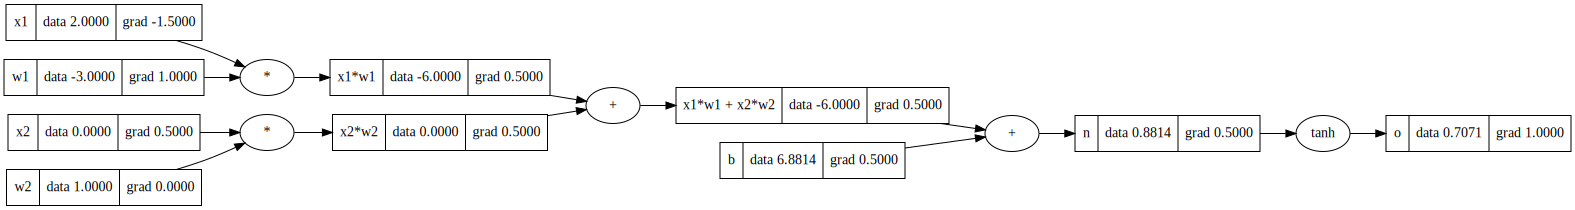

In [32]:
draw_dot(o)

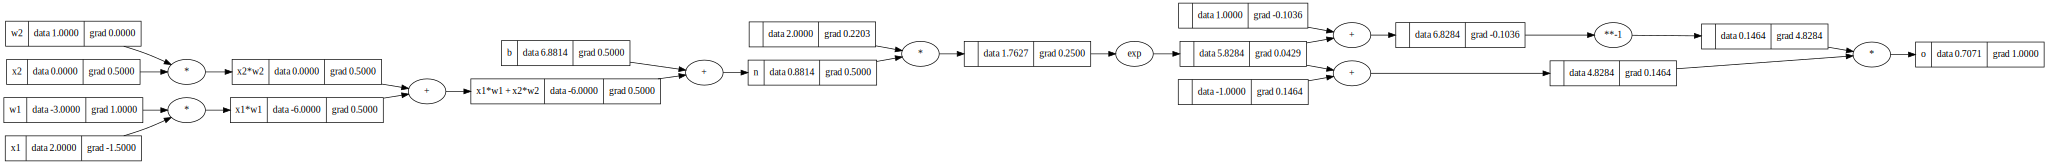

In [38]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
# derivative of tanh
e = (2*n).exp()
o = (e - 1)/ (e+1)
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
# INPUT AND OUTPUT
# OUTPUT FUCNTION OF INPUT
# FORWARD PASS AND BACKWARD PASS OF OPERATIONS, DOESN'T MATTER ABOUT COMPOSITE OF OPERATION
# DESIGN OF FUNCTIONS UP TO YOU

In [42]:
import torch

In [48]:
# python uses double
# default data type is float32 for tensor, therefore need to convert
# require gradients given that they are all leaf nodes (set to false normally)
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# need to call .item (takes single tensor of one element, stripping away tensor)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [62]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [66]:
x2.grad.item()

0.5000001283844369

In [46]:
torch.Tensor([[1,2,3], [4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [157]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        # zip pairs tuples
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin,  nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  # create multiple layers (nouts -> number of layers)
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

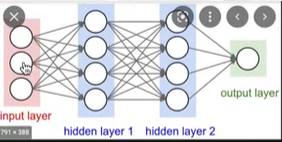

In [159]:
from PIL import Image
from IPython.display import display
img = Image.open('chrome_Dwkl7j1JKS.png')
display(img)

In [340]:
# above diagram shown below
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6056444711550096)

In [163]:
# draw_dot(x(n))

In [165]:
n.parameters()

[Value(data=-0.02262536799297621),
 Value(data=-0.5839446326408608),
 Value(data=-0.48331517710864236),
 Value(data=0.8968380614682052),
 Value(data=0.2931185925522133),
 Value(data=-0.47663382755622785),
 Value(data=0.06202885732619601),
 Value(data=-0.443536646917301),
 Value(data=0.05233852559506391),
 Value(data=-0.029510882528702265),
 Value(data=0.5918446187985604),
 Value(data=-0.9154715656076577),
 Value(data=0.8781390312555777),
 Value(data=-0.7671972634703774),
 Value(data=0.5394152900502958),
 Value(data=0.24597579079075804),
 Value(data=-0.28391258105270123),
 Value(data=-0.32510016818481535),
 Value(data=-0.6117889718834641),
 Value(data=-0.15014651130502843),
 Value(data=-0.06312360499555791),
 Value(data=-0.19697184954186153),
 Value(data=-0.5823953017103756),
 Value(data=0.3738604232649876),
 Value(data=-0.24222549274848637),
 Value(data=0.1507252771261578),
 Value(data=0.6647200314011195),
 Value(data=-0.9344621546018177),
 Value(data=0.3172087358719313),
 Value(data=-

In [342]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
# input data given, don't change
# gradients for neural network parameters, therefore we want to change them


# n is the defined MLP - multilayer perceptron
# input addinto MLP
# not performing well given ys and ypred are so different

In [169]:
ypred = [n(x) for x in xs]
# calculate single number to calcualte performance on neural net
# pair up ground truth with prediction and calculate MSE (quality of predictor/estimator)
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss
# get 0 if prediction, otherwise high loss means further apart

Value(data=4.992702229665077)

In [173]:
# n.layers[0].neurons[0].w[0].grad
# n.layers[0].neurons[0].w[0].data

-1.6595487371770792

In [315]:
# forward pass for loss function (repeat bottom 3 commands to improve predictions)
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.00020394848932207425)

In [317]:
# backward pass
loss.backward()

In [319]:
# update parameters in relevant direction
for p in n.parameters():
    p.data += -0.01 * p.grad
    # learning rate is 0.01, too low takes a long time, too high overstep

In [321]:
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred

[Value(data=0.9895663803805099),
 Value(data=-0.9985059850054785),
 Value(data=-0.9951465749622533),
 Value(data=0.9916753224953164)]

In [323]:
# setting of weights and biases, for network to predict desired targets
n.parameters()

[Value(data=0.5645724914520465),
 Value(data=-0.4573351965748101),
 Value(data=0.9583016469597334),
 Value(data=1.6270708289731906),
 Value(data=-0.33707557013194844),
 Value(data=-0.594861855017841),
 Value(data=1.1954444747571717),
 Value(data=-0.6434439412977578),
 Value(data=1.262099813371045),
 Value(data=-0.19307659331664667),
 Value(data=1.198152251274323),
 Value(data=-0.2879375602979139),
 Value(data=0.07026698388921132),
 Value(data=-1.413172737446776),
 Value(data=1.94553763656333),
 Value(data=-0.28424234411974875),
 Value(data=0.03933580343287093),
 Value(data=-0.957767083228112),
 Value(data=-1.22549808482176),
 Value(data=-1.7943176947443376),
 Value(data=-0.6621172380983709),
 Value(data=0.3254631723706465),
 Value(data=-1.1889453090248692),
 Value(data=-0.4582048849476309),
 Value(data=-1.9309601572835045),
 Value(data=-0.29399679938057),
 Value(data=1.1700866030362158),
 Value(data=-0.6214343206911217),
 Value(data=0.1210344381794748),
 Value(data=0.19725097086170434)

In [356]:
# now make it more respectable and do loop
# GRADIENT DESCENT
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass, reset back to 0, so accumualte
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.002966228248043688
1 0.0029380421122913863
2 0.0029104617251853367
3 0.0028834669942990093
4 0.0028570387173495098
5 0.0028311585331857935
6 0.0028058088759890893
7 0.002780972932442045
8 0.0027566346016441026
9 0.002732778457569531
10 0.0027093897138813776
11 0.0026864541909305787
12 0.0026639582847830337
13 0.0026418889381305474
14 0.0026202336129530534
15 0.0025989802648100275
16 0.0025781173186488386
17 0.002557633646026376
18 0.0025375185436482743
19 0.0025177617131377627


In [358]:
ypred

[Value(data=0.9838543086872641),
 Value(data=-0.971594409845602),
 Value(data=-0.9666739493565575),
 Value(data=0.9815724347331863)]